In [12]:
%pylab inline
import re
import pandas as pd
from collections import Counter
from collections import OrderedDict

import matplotlib
import seaborn as sns
import pyupset as pyu
from riboraptor.helpers import path_leaf


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style('white')
sns.set_context('paper', font_scale=2)

def strip_tx_version(txid):
    return re.sub('\.\d+', '', txid)

Populating the interactive namespace from numpy and matplotlib


In [3]:
mouse_files  = ['/home/cmb-panasas2/wenzhenl/benchmark/uorfs/mouse/SRP003554_mouse/SRX026871_translating_ORFs.tsv',
           '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/mouse/SRP062407_mouse/SRX1149649_translating_ORFs.tsv',
           '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/mouse/SRP078005_mouse/SRX1900396_translating_ORFs.tsv',
           '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/mouse/SRP091889_mouse/SRX2255510_translating_ORFs.tsv',
           '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/mouse/SRP115915_mouse/SRX3110803_translating_ORFs.tsv']


human_files = ['/home/cmb-panasas2/wenzhenl/benchmark/uorfs/human/SRP010679_human/SRX118286_translating_ORFs.tsv',
               '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/human/SRP063852_human/SRX1254413_translating_ORFs.tsv',
               '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/human/SRP098789_human/SRX2536421_translating_ORFs.tsv',
               '/home/cmb-panasas2/wenzhenl/benchmark/uorfs/human/SRP102021_human/SRX2647167_translating_ORFs.tsv']


In [30]:
def read_cds_uorfs_startcodons(filelist):
    cds = OrderedDict()
    uorfs = OrderedDict()
    start_codons = OrderedDict()
    cds_df = pd.DataFrame()
    uorfs_df = pd.DataFrame()
    start_codons_df = pd.DataFrame()
    for fin in filelist:
        key = path_leaf(fin).replace('_translating_ORFs.tsv', '')
        df = pd.read_table(fin, header=0, sep='\t', usecols=['ORF_ID', 'ORF_type', 'status', 'length', 'transcript_id', 'gene_id', 'gene_name', 'start_codon'])
        a = df.loc[(df['ORF_type'] == 'annotated') & (df['status'] == 'translating'), 'gene_id'].tolist()        
        cds_df_key = pd.DataFrame(list(set(a)), columns=['gene_id']).set_index('gene_id')
        cds_df_key[key] = 1
        cds_df = cds_df.join(cds_df_key, how='outer')
        b = df.loc[(df['ORF_type'] == 'super_uORF') & (df['status'] == 'translating'), 'gene_id'].tolist()        
        uorfs_df_key = pd.DataFrame(list(set(b)), columns=['gene_id']).set_index('gene_id')
        uorfs_df_key[key] = 1
        uorfs_df = uorfs_df.join(uorfs_df_key, how='outer')
        
        s = df.loc[(df['ORF_type'] == 'super_uORF') & (df['status'] == 'translating'), 'start_codon'].tolist()
        start_codons_df_key = pd.DataFrame.from_dict(Counter(s), orient='index', columns=[key])
        start_codons_df = start_codons_df.join(start_codons_df_key, how='outer')
        
        start_codons[key] = s
    cds_df = cds_df.fillna(0)
    cds_df = cds_df.astype(int)
    
    uorfs_df = uorfs_df.fillna(0)
    uorfs_df = uorfs_df.astype(int)
    
    start_codons_df = start_codons_df.fillna(0)
    start_codons_df = start_codons_df.astype(int)
    
    cds_df = cds_df.sort_index().reset_index()
    cds_df['gene_id'] = cds_df['gene_id'].apply(strip_tx_version)
    
    uorfs_df = uorfs_df.sort_index().reset_index()
    uorfs_df['gene_id'] = uorfs_df['gene_id'].apply(strip_tx_version)
    
    start_codons_df = start_codons_df.sort_index().reset_index().rename(columns={'index': 'codon'})
    
    
    return cds_df, uorfs_df, start_codons_df

In [31]:
human_cds, human_uorfs, human_start_codons = read_cds_uorfs_startcodons(human_files)

In [134]:
a = """
SRP010679 & 9246 & 764  & 8\%  & 105\\
SRP063852 & 12744 & 3263   & 26\% & 54\\
SRP098789 & 10546 & 1028 & 10\% & 72\\
SRP102021 & 9520 & 1401 & 15\% & 199\\
SRP003554 & 10369 & 2755 & 27\% & 70\\
SRP062407 & 14542 & 3648 &  25\% & 47\\
SRP078005 & 10564 & 1165 & 11\% & 56\\
SRP091889 & 12739 & 3128 & 25\% & 187\\
SRP115915 & 11264 & 1854 & 16\% & 148\\
"""
a = a.replace("  ", " ").replace('\%', '').strip()
data = []
for line in a.split('\\'):
    line = line.strip()
    if len(line.split()):
        data.append(line.split(' & '))
data_df = pd.DataFrame(data)
data_df.columns = ['SRP', 'CDS', 'uORF', 'percentage', 'only_uorf']
data_df['species'] = ['human'] * 4 + ['mouse']*5
data_df.to_csv('../uorfs/human_mouse_uorf_cds_summary.tsv', sep='\t', header=True, index=False)


In [142]:
data_df.iloc[:4].percentage.astype(int).mean()

14.75

In [143]:
data_df.iloc[4:].percentage.astype(int).mean()

20.8

In [106]:
human_cds_gene_ids = human_cds['gene_id'].tolist()
human_uorfs_gene_ids = human_uorfs['gene_id'].tolist()

all_cds = len(set(human_cds_gene_ids))
union = len(set(human_cds_gene_ids).union(set(human_uorfs_gene_ids)))
intersection = len(set(human_cds_gene_ids).intersection(set(human_uorfs_gene_ids)))

all_uorfs = len(set(human_uorfs_gene_ids))
data = [('CDS', all_cds), ('uORF', all_uorfs), ('union', union), ('intersection', intersection)]
df = pd.DataFrame(data, columns=['region', 'value'])
df.to_csv('../uorfs/human_uorf_cds_counts.tsv', index=False, header=True, sep='\t')

In [107]:
all_uorfs/union

0.2984827784568922

In [108]:
intersection/union

0.29424031063493206

In [109]:
mouse_cds_gene_ids = mouse_cds['gene_id'].tolist()
mouse_uorfs_gene_ids = mouse_uorfs['gene_id'].tolist()

all_cds = len(set(mouse_cds_gene_ids))
union = len(set(mouse_cds_gene_ids).union(set(mouse_uorfs_gene_ids)))
intersection = len(set(mouse_cds_gene_ids).intersection(set(mouse_uorfs_gene_ids)))

all_uorfs = len(set(mouse_uorfs_gene_ids))
data = [('CDS', all_cds), ('uORF', all_uorfs), ('union', union), ('intersection', intersection)]
df = pd.DataFrame(data, columns=['region', 'value'])
df.to_csv('../uorfs/mouse_uorf_cds_counts.tsv', index=False, header=True, sep='\t')

In [110]:
all_uorfs/union

0.3782027706264558

In [33]:
human_uorfs.to_csv('../uorfs/human_uorf_codon_summary.tsv', index=False, header=True, sep='\t')

In [34]:
mouse_cds, mouse_uorfs, mouse_start_codons = read_cds_uorfs_startcodons(mouse_files)

In [36]:
mouse_start_codons.to_csv('../uorfs/mouse_uorf_codon_summary.tsv', index=False, header=True, sep='\t')

In [70]:
mouse_start_codons_melt = pd.melt(mouse_start_codons, id_vars=['codon']).rename(columns={'variable': 'dataset'})
mouse_start_codons_melt.codon = mouse_start_codons_melt.codon.apply(lambda x: x.replace('T', 'U'))
mouse_start_codons_melt.to_csv('../uorfs/mouse_uorf_codon_summary_longform.tsv', index=False, header=True, sep='\t')


In [69]:
human_start_codons_melt = pd.melt(human_start_codons, id_vars=['codon']).rename(columns={'variable': 'dataset'})
human_start_codons_melt.codon = human_start_codons_melt.codon.apply(lambda x: x.replace('T', 'U'))
human_start_codons_melt.to_csv('../uorfs/human_uorf_codon_summary_longform.tsv', index=False, header=True, sep='\t')


In [89]:
human_start_codons_melt_std = human_start_codons_melt.groupby(['codon']).agg(['mean', 'std']).reset_index()
human_start_codons_melt_std.reset_index(drop=True)
human_start_codons_melt_std.to_csv('../uorfs/human_uorf_codon_summary_mean_std.tsv', index=False, header=True, sep='\t')

In [90]:
mouse_start_codons_melt_std = mouse_start_codons_melt.groupby(['codon']).agg(['mean', 'std']).reset_index()
mouse_start_codons_melt_std.reset_index(drop=True)
mouse_start_codons_melt_std.to_csv('../uorfs/mouse_uorf_codon_summary_mean_std.tsv', index=False, header=True, sep='\t')

In [19]:
human_uorfs.to_csv('../uorfs/human_uorf_genewise_summary.tsv', index=False, header=True, sep='\t')

In [20]:
mouse_uorfs.to_csv('../uorfs/mouse_uorf_genewise_summary.tsv', index=False, header=True, sep='\t')

In [42]:
human_cds.to_csv('../uorfs/human_cds_codon_summary.tsv', index=False, header=True, sep='\t')

In [43]:
mouse_cds.to_csv('../uorfs/mouse_cds_codon_summary.tsv', index=False, header=True, sep='\t')

In [51]:
mouse_uorf_sum = pd.DataFrame(mouse_uorfs.sum())
mouse_uorf_sum = mouse_uorf_sum.iloc[1:].reset_index().rename(columns={'index': 'dataset', 0: 'value'})
mouse_uorf_sum['region_type'] = 'uORF'

mouse_cds_sum = pd.DataFrame(mouse_cds.sum())
mouse_cds_sum = mouse_cds_sum.iloc[1:].reset_index().rename(columns={'index': 'dataset', 0: 'value'})
mouse_cds_sum['region_type'] = 'CDS'

mouse_uorf_cds = pd.concat([mouse_uorf_sum, mouse_cds_sum])
mouse_uorf_cds.to_csv('../uorfs/mouse_uorf_cds_summary.tsv', index=False, header=True, sep='\t')

In [52]:
human_uorf_sum = pd.DataFrame(human_uorfs.sum())
human_uorf_sum = human_uorf_sum.iloc[1:].reset_index().rename(columns={'index': 'dataset', 0: 'value'})
human_uorf_sum['region_type'] = 'uORF'

human_cds_sum = pd.DataFrame(human_cds.sum())
human_cds_sum = human_cds_sum.iloc[1:].reset_index().rename(columns={'index': 'dataset', 0: 'value'})
human_cds_sum['region_type'] = 'CDS'

human_uorf_cds = pd.concat([human_uorf_sum, human_cds_sum])
human_uorf_cds.to_csv('../uorfs/human_uorf_cds_summary.tsv', index=False, header=True, sep='\t')

# Plots 

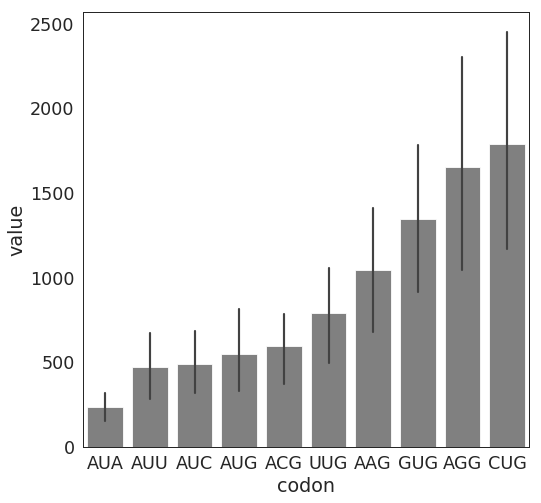

In [68]:
mouse_start_codons_melt = pd.melt(mouse_start_codons, id_vars=['codon']).rename(columns={'variable': 'dataset'})
mouse_start_codons_melt.codon = mouse_start_codons_melt.codon.apply(lambda x: x.replace('T', 'U'))
mouse_start_codons_melt = mouse_start_codons_melt.sort_values(['value']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(data=mouse_start_codons_melt, y='value', x='codon', color='grey', ax=ax)


In [60]:
mouse_start_codons_melt.codon = mouse_start_codons_melt.codon.apply(lambda x: x.replace('T', 'U'))

In [135]:
mouse_start_codons_melt

,codon,dataset,value
0,AAG,SRX026871,1072
1,ACG,SRX026871,692
2,AGG,SRX026871,1788
3,AUA,SRX026871,250
4,AUC,SRX026871,507
5,AUG,SRX026871,484
6,AUU,SRX026871,511
7,CUG,SRX026871,1912
8,GUG,SRX026871,1478
9,UUG,SRX026871,883
